<a href="https://colab.research.google.com/github/jhonatantft/crypto-analysis/blob/main/crypto_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Bidirectional, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.callbacks import EarlyStopping

import numpy as np

In [ ]:
os.listdir("./coins/")

['coin_Ethereum.csv',
 'coin_Cardano.csv',
 'coin_NEM.csv',
 'coin_Tether.csv',
 'coin_ChainLink.csv',
 'coin_Polkadot.csv',
 'coin_Aave.csv',
 'coin_EOS.csv',
 'coin_WrappedBitcoin.csv',
 'coin_Solana.csv',
 'coin_Stellar.csv',
 'coin_Litecoin.csv',
 'coin_Bitcoin.csv',
 'coin_Cosmos.csv',
 'coin_CryptocomCoin.csv',
 'coin_BinanceCoin.csv',
 'coin_Iota.csv',
 'coin_Dogecoin.csv',
 'coin_Uniswap.csv',
 'coin_Monero.csv',
 'coin_USDCoin.csv',
 'coin_XRP.csv',
 'coin_Tron.csv']

In [ ]:
# Carregar os datasets
#Será carregado cada crypto em um dataframe e na sequência todos os dataframes estarão organizados em um dicionário

coin_dataframes = {}

for fn in os.listdir('./coins/'):
  coin_name = fn.split('_')[1].split('.')[0]
  df = pd.read_csv(os.path.join("./coins/", fn), parse_dates=["Date"])
  coin_dataframes[coin_name] = df.sort_values('Date')

In [ ]:
coin_dataframes.keys()

dict_keys(['Ethereum', 'Cardano', 'NEM', 'Tether', 'ChainLink', 'Polkadot', 'Aave', 'EOS', 'WrappedBitcoin', 'Solana', 'Stellar', 'Litecoin', 'Bitcoin', 'Cosmos', 'CryptocomCoin', 'BinanceCoin', 'Iota', 'Dogecoin', 'Uniswap', 'Monero', 'USDCoin', 'XRP', 'Tron'])

In [ ]:
# Cada dataframe será dessa forma
coin_dataframes['Cardano'].head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


<Figure size 1440x576 with 0 Axes>

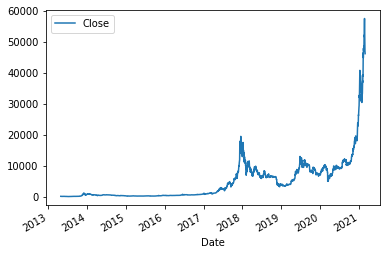

In [ ]:
# Crescimento do valor do Bitcoin
plt.figure(figsize=(20,8))
coin_dataframes['Bitcoin'].plot(x='Date', y='Close')
plt.show()

In [ ]:
# Crescimento relativo e outros valores relativos
# Esses valores serão adicionados ao dataframe

def add_relative_columns(df):
    day_diff = df['Close'] - df['Open']
    df['relative_close'] = day_diff / df['Open']
    df['high_low_ratio'] = df['High'] / df['Low']
    df['relative_high'] = df['High'] / df['Close']
    df['relative_low'] = df['Low'] / df['Close']

for df in coin_dataframes.values():
    add_relative_columns(df)
    
coin_dataframes["Cardano"].head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,relative_close,high_low_ratio,relative_high,relative_low
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08,0.053838,1.506698,1.160263,0.770070
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08,-0.191827,1.325536,1.317518,0.993952
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08,0.051160,1.093088,1.039888,0.951330
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08,-0.021074,1.062049,1.030942,0.970710
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08,-0.132020,1.173325,1.161971,0.990323


In [ ]:
# Criando dados históricos para treinamento
# O histórico terá dado dos últimos 10 dias para cada dia


def create_history_frames(coin_dataframes):
    history_frames = {}
    for coin_name, df in coin_dataframes.items():
        history_frames[coin_name], x_cols = create_history_frame(df)
    return history_frames, x_cols
        
def create_history_frame(df):
    feature_cols = ['relative_close', 'relative_high', 'relative_low', 'high_low_ratio']
    y_col = ['relative_close']
    x_cols = []
    days = 10
    history = df[['Date'] + y_col].copy()
    for n in range(1, days+1):
        for feat_col in feature_cols:
            colname = '{}_{}'.format(feat_col, n)
            history[colname] = df[feat_col].shift(n)
            x_cols.append(colname)
    history = history[days:]
    return history, x_cols

y_col = 'relative_close'
coin_history, x_cols = create_history_frames(coin_dataframes)
#coin_history

In [ ]:
# Definindo um model
# Será treinado um model diferente para cada crypto

# LSTM do Keras (Long Short-Term Memory layer)

def create_model():
    input_layer = Input(batch_shape=(None, len(x_cols), 1))
    layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    layer = Bidirectional(LSTM(128))(layer)
    out = Dense(1, activation="sigmoid")(layer)
    m = Model(inputs=input_layer, outputs=out)
    m.compile("rmsprop", loss='mean_squared_error')
    return m

def create_train_test_mtx(history):
    X = history[x_cols].to_numpy()
    y = history[y_col].to_numpy()
    X = X.reshape(X.shape[0], X.shape[1], 1)
    rand_mtx = np.random.permutation(X.shape[0])
    train_split = int(X.shape[0] * 0.9)
    train_indices = rand_mtx[:train_split]
    test_indices = rand_mtx[train_split:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def train_model(model, X, y):
    ea = EarlyStopping(monitor='val_loss', patience=2)
    # val_loss = model.fit(X, y, epochs=500, batch_size=64, callbacks=[ea], verbose=1, validation_split=.1)
    val_loss = model.fit(X, y, epochs=5, batch_size=64, callbacks=[ea], verbose=1, validation_split=.1)
    return val_loss

In [ ]:
# Treinamento do modelo para cada cripto
# Será salvo cada predição no seu test set

rmse = {}
pred = {}
test = {}

for coin_name, history in coin_history.items():
    model = create_model()
    X_train, X_test, y_train, y_test = create_train_test_mtx(history)
    train_model(model, X_train, y_train)
    test[coin_name] = y_test
    
    # Predição no set test
    pred[coin_name] = model.predict(X_test)

    # Cálculo de erro em test
    rmse[coin_name] = np.sqrt(np.mean((pred[coin_name] - y_test)**2))
    print(coin_name, rmse[coin_name])

Epoch 1/5
26/26 [==============================] - 33s 687ms/step - loss: 0.0473 - val_loss: 0.0040
Epoch 2/5
26/26 [==============================] - 14s 540ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/5
26/26 [==============================] - 14s 546ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 4/5
26/26 [==============================] - 14s 547ms/step - loss: 0.0041 - val_loss: 0.0040
Ethereum 0.054510204508767576
Epoch 1/5
16/16 [==============================] - 30s 811ms/step - loss: 0.0714 - val_loss: 0.0048
Epoch 2/5
16/16 [==============================] - 9s 548ms/step - loss: 0.0108 - val_loss: 0.0046
Epoch 3/5
16/16 [==============================] - 9s 544ms/step - loss: 0.0109 - val_loss: 0.0047
Epoch 4/5
16/16 [==============================] - 9s 550ms/step - loss: 0.0072 - val_loss: 0.0047
Cardano 0.07257511886694216
Epoch 1/5
28/28 [==============================] - 36s 688ms/step - loss: 0.0484 - val_loss: 0.0051
Epoch 2/5
28/28 [============================

In [ ]:
# Análise pós treinamento


pred_sign = {coin_name: np.sign(pred[coin_name]) * np.sign(test[coin_name]) for coin_name in pred.keys()}
coin_list = {}
for coin, val in sorted(pred_sign.items()):
    cnt = np.unique(pred_sign[coin], return_counts=True)[1]
    # print("[{}] Resultados positivos/negativos econtrados corretamente: {}, incorretamente: {}, Percentual de acerto: {}".format(
    #     coin, cnt[0], cnt[1], cnt[0]/ (cnt[0] + cnt[1]) * 100) + '\n')
    coin_list[coin] = {}
    coin_list[coin]['correct'] = cnt[0]
    coin_list[coin]['incorrect'] = cnt[1]
    coin_list[coin]['correct_percent'] = (cnt[0] / (cnt[0] + cnt[1]) * 100)

sorted_coin_list = sorted(coin_list.items(), key=lambda x: x[1]['correct_percent'])
# Ordenados por percentual de acerto
for coin in sorted_coin_list:
  print('[' + coin[0] + '] Restultados positivos/negativos encontrados corretamente: ' + str(coin[1]['correct']) +
    ', ' + 'incorretamente: ' + str(coin[1]['incorrect']) + ', percentual de acerto: ' + str(int(coin[1]['correct_percent'])) + '\n')

[Polkadot] Restultados positivos/negativos encontrados corretamente: 133, incorretamente: 228, percentual de acerto: 36

[Aave] Restultados positivos/negativos encontrados corretamente: 84, incorretamente: 112, percentual de acerto: 42

[Solana] Restultados positivos/negativos encontrados corretamente: 448, incorretamente: 576, percentual de acerto: 43

[WrappedBitcoin] Restultados positivos/negativos encontrados corretamente: 2475, incorretamente: 3150, percentual de acerto: 44

[Cosmos] Restultados positivos/negativos encontrados corretamente: 2343, incorretamente: 2698, percentual de acerto: 46

[Cardano] Restultados positivos/negativos encontrados corretamente: 7316, incorretamente: 8060, percentual de acerto: 47

[Dogecoin] Restultados positivos/negativos encontrados corretamente: 33138, incorretamente: 36031, percentual de acerto: 47

[Bitcoin] Restultados positivos/negativos encontrados corretamente: 39468, incorretamente: 42328, percentual de acerto: 48

[USDCoin] Restultados p

In [ ]:
# Após analisar os resultados acima é possível chegar a conclusão que através do modelo preditivo criado
# a partir dos parâmetros especificados (epochs, batch_size, etc), a lista apresenta as moedas com o seu
# respectivo percetual de acerto em ordem crescente.

# Dessa forma é válido afirmar que quanto maior o percentual de acerto da criptomoeda, mais estável é a
# criptomoeda para um possível investimento real, pois a criptomoeda tende a fazer movimentos previsíveis.
# De todas as criptomoedas, a mais segura seria a Uniswap. A mais instável e volátil seria a Polkadot.

# No entanto, é válido criar outros modelos com parâmetros diferentes (por exemplo epochs = 500), e até mesmo
# outro tipo de rede que seja diferente da layer utilizada aqui (LSTM - Keras).